# Imports

In [1]:
from collections import deque, defaultdict
import matplotlib.pyplot as plt
from math import ceil
from tqdm import tqdm
import numpy as np
import random
import time

# Snake Environment

In [2]:
class SnakeEnvironment():
    def __init__(self, grid_size = (12, 12)):
        self.grid_size = grid_size
    
    def get_feature_vector(self, tile_size = 3):
        
        snake_set = set(self.snake)
        
        # -----------------CREATING 11 BOOLEAN REPRESENTATION-----------------
        sub_feature = np.zeros(11, dtype=bool)

        # -----------------danger around head-----------------
        if self.direction == 0:
            left = (self.head[0], self.head[1] + 1)
            front = (self.head[0] + 1, self.head[1])
            right = (self.head[0], self.head[1] - 1)
        elif self.direction == 1:
            left = (self.head[0] - 1, self.head[1])
            front = (self.head[0], self.head[1] + 1)
            right = (self.head[0] + 1, self.head[1])
        elif self.direction == 2:
            left = (self.head[0], self.head[1] - 1)
            front = (self.head[0] - 1, self.head[1])
            right = (self.head[0], self.head[1] + 1)
        elif self.direction == 3:
            left = (self.head[0] + 1, self.head[1])
            front = (self.head[0], self.head[1] - 1)
            right = (self.head[0] - 1, self.head[1])

        if not((0 <= left[0] < self.grid_size[0]) and (0 <= left[1] < self.grid_size[1])):
            sub_feature[0] = True
        elif left in snake_set:
            sub_feature[0] = True
        
        if not((0 <= front[0] < self.grid_size[0]) and (0 <= front[1] < self.grid_size[1])):            
            sub_feature[1] = True
        elif front in snake_set:
            sub_feature[1] = True

        if not((0 <= right[0] < self.grid_size[0]) and (0 <= right[1] < self.grid_size[1])):
            sub_feature[2] = True
        elif right in snake_set:
            sub_feature[2] = True

        # -----------------direction of head-----------------
        sub_feature[self.direction + 3] = True

        # -----------------direction of food-----------------
        if self.food[0] > self.head[0]:
            sub_feature[7] = True
        if self.food[1] > self.head[1]:
            sub_feature[8] = True
        if self.food[0] < self.head[0]:
            sub_feature[9] = True
        if self.food[1] < self.head[1]:
            sub_feature[10] = True

        # -----------------CREATING SNAKE BODY TILING REPRESENTATION-----------------
        snake_set = set(self.snake)
        tile_grid = np.zeros((ceil(self.grid_size[0] / tile_size), ceil(self.grid_size[1] / tile_size)), dtype=bool)

        
        for i in range(self.grid_size[0]):
            for j in range(self.grid_size[1]):
                if (i, j) in snake_set:
                    tile_grid[i//tile_size][j//tile_size] = True
           
        return tuple(np.concatenate((sub_feature, tile_grid.flatten())))
        # return tuple(sub_feature)

    def generate_food(self):
        snake_set = set(self.snake)
        
        while True:
            self.food = (random.randint(0, self.grid_size[0] - 1), random.randint(0, self.grid_size[1] - 1))
            if not self.food in snake_set:
                break
    
    def reset(self):
        self.head = (random.randint(0, self.grid_size[0] - 1), random.randint(0, self.grid_size[1] - 1))
        self.direction = random.randint(0, 3)
        
        self.snake = deque()
        self.snake.append(self.head)

        self.generate_food()

        self.didnt_eat_counter = 0
        
        return self.get_feature_vector()
    
    def step(self, action):
        if action == 'down' and self.direction == 2:
            action = 'up'
        elif action == 'right' and self.direction == 3:
            action = 'left'
        elif action == 'up' and self.direction == 0:
            action = 'down'
        elif action == 'left' and self.direction == 1:
            action = 'right'
        
        if action == 'down':
            next_head = (self.head[0] + 1, self.head[1])
            self.direction = 0
        elif action == 'right':
            next_head = (self.head[0], self.head[1] + 1)
            self.direction = 1
        elif action == 'up':
            next_head = (self.head[0] - 1, self.head[1])
            self.direction = 2
        elif action == 'left':
            next_head = (self.head[0], self.head[1] - 1)
            self.direction = 3
        else: 
            return
        
        # if snake touches border
        if not (0 <= next_head[0] < self.grid_size[0]):
            return self.get_feature_vector(), -100, True

        if not (0 <= next_head[1] < self.grid_size[1]):
            return self.get_feature_vector(), -100, True

        # if snake touches itself
        if next_head in set(list(self.snake)[1:]):
            return self.get_feature_vector(), -100, True

        self.snake.append(next_head)
        self.head = next_head

        # if snake ate food
        if next_head == self.food:
            self.generate_food()
            self.didnt_eat_counter = 0
            return self.get_feature_vector(), 100, False    
        
        # snake moves normally
        self.snake.popleft()
        self.didnt_eat_counter += 1
        
        if self.didnt_eat_counter > 20:
            return self.get_feature_vector(), -100, True
        else:
            return self.get_feature_vector(), -1, False
  
    def render(self):
        snake_set = set(self.snake)
        
        for i in range(self.grid_size[0]):
            for j in range(self.grid_size[1]):
                if (i, j) in snake_set:
                    print(' ● ', end='')
                elif (i, j) == self.food:
                    print(' ◍ ', end='')
                else:
                    print(' - ', end='')
            print()

# Agent

In [3]:
class Agent():
    def __init__(self, alpha=0.5, gamma=1, eps=0.1):
        self.alpha = alpha
        self.gamma = gamma
        self.eps = eps
        self.Q = defaultdict(lambda: -100)

        self.action_space= ['down', 'right', 'up', 'left']
        
    def greedy(self, state):        
        max_action = self.action_space[0]
        max_Q = self.Q[state, max_action]
        
        for action in self.action_space:
            if self.Q[state, action] > max_Q:
                max_action = action
                max_Q = self.Q[state, action]
                
        return max_action
    
    def e_greedy(self, state):
        if np.random.random() > self.eps:
            return self.greedy(state)
        else:
            random_action = np.random.choice(self.action_space)
            return random_action

    def update(self, reward, state, action, next_state, next_action):
        if reward == 0:
            next_Q = 0
        else:
            next_Q = self.Q[next_state, next_action]
        self.Q[state, action] += self.alpha * ( reward + self.gamma*next_Q - self.Q[state,action] )

# Gameplay

In [4]:
env = SnakeEnvironment()
agent = Agent()
N_action_list = []

for episode in tqdm(range(20000), desc="Processing", unit="item"):
    N_actions = 0
    state = env.reset()
    action = agent.e_greedy(state)
    done = False
    
    while True:
        next_state, reward, done = env.step(action)        
        next_action = agent.e_greedy(next_state)
        agent.update(reward, state, action, next_state, next_action)
        state = next_state
        action = next_action
        N_actions += 1
        if done:
            N_action_list.append(N_actions)
            break

Processing: 100%|█████████████████████████████████████████████████████████████| 20000/20000 [00:37<00:00, 526.81item/s]


# Gameplay summary

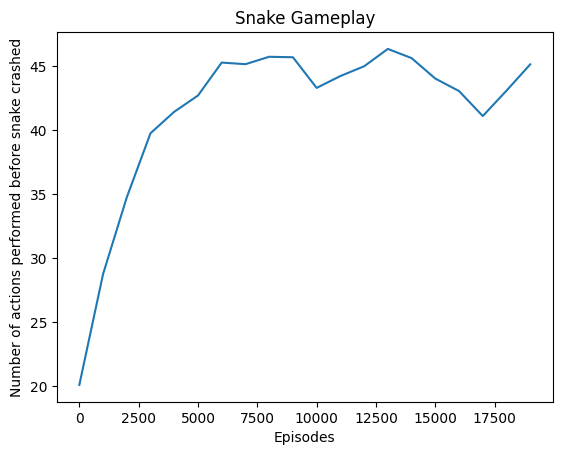

In [5]:
window_size = 1000
averages = []

for i in range(0, len(N_action_list), window_size):
    window = N_action_list[i:i+window_size]
    average = sum(window) / len(window)
    averages.append(average)

x_values = list(range(0, len(N_action_list), window_size))

plt.plot(x_values, averages)
plt.xlabel("Episodes")
plt.ylabel("Number of actions performed before snake crashed")
plt.title("Snake Gameplay");

## **Proposed Enhancements:**
### Random actions by the snake are often a result of an unanticipated game state.
### The current problem statement suggests that Q learning with TD(0) may not be the optimal approach.
### Introducing additional tiling information exacerbates the issue of unknown states.